#### 1. Setup & Imports

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer # tabular data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score 

import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers, callbacks, utils 
utils.set_random_seed(42)   # reproducibility 

#### 2. Load and Inspect the data

In [15]:
data = load_breast_cancer()
X, y = data.data, data.target
df = pd.DataFrame(X, columns=data.feature_names)
print(df.head())
print("Class balance: ", np.bincount(y))
# df.head()

   mean radius  mean texture  ...  worst symmetry  worst fractal dimension
0        17.99         10.38  ...          0.4601                  0.11890
1        20.57         17.77  ...          0.2750                  0.08902
2        19.69         21.25  ...          0.3613                  0.08758
3        11.42         20.38  ...          0.6638                  0.17300
4        20.29         14.34  ...          0.2364                  0.07678

[5 rows x 30 columns]
Class balance:  [212 357]


### 3. Train / Validation / Test Split 

In [19]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)

Rule of thumb: hold out ≈ 15‑20 % for final testing; carve validation from the rest.

### 4. Feature Scaling

In [21]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Standardization stabilizes gradient descent and lets BatchNorm start closer to identity.

### 5. Build the Network

In [30]:
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),  # 30 features 
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),              # BN 
    layers.Dropout(0.30),                     # BO
    layers.Dense(32, activation='relu'), 
    layers.BatchNormalization(), 
    layers.Dropout(0.30), 
    layers.Dense(1, activation='sigmoid')     # binary output, sigmoid activation for binary classification
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 64)                  │           1,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,481 (17.50 KB)

 Trainable params: 4,289 (16.75 KB)

 Non-trainable params: 192 (768.00 B)

| Technique | Why it matters on tabular data |
| --- | --- |
| **Batch Normalization** | Stabilizes layer activations, speeds convergence, reduces dependence on initialization. |
| **Dropout** | Cheap regularization against over‑fitting when feature count is modest and data are noisy. |

### 6 · Compile & Early‑Stopping Callback

In [ ]:
# 1. Configure the learning process 
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 2. Define a safeguard against overfitting (Early Stopping) 
early_stop = callbacks.EarlyStopping(
    patience = 10,                   # stop if no val-improvements in 10 epochs 
    restore_best_weights=True,       # rollback to champion epoch 
    verbose=1                        # prints a message when stopping occurs 
)

### 7 · Train & Visualize

Epoch 71: early stopping
Restoring model weights from the end of the best epoch: 61.


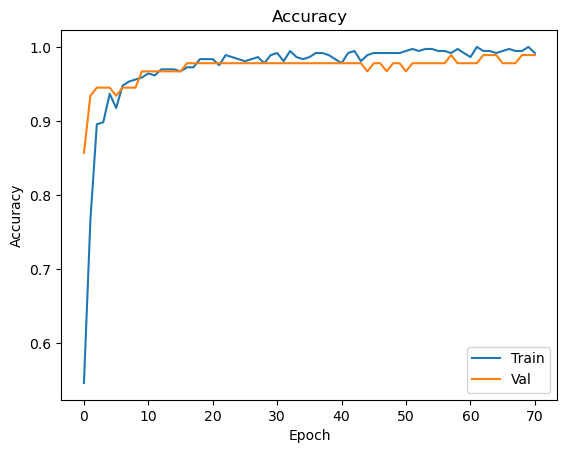

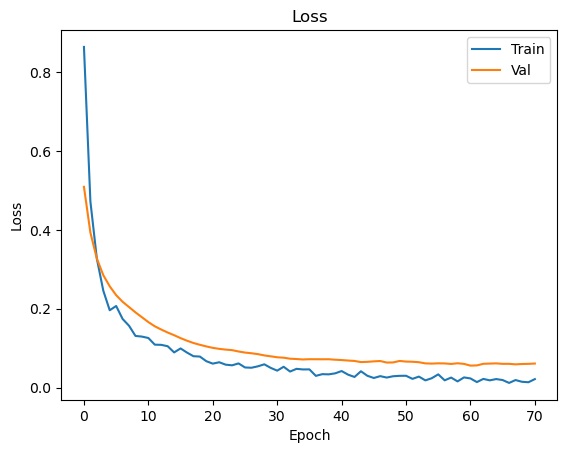

In [34]:
history = model.fit(
    X_train, y_train, 
    validation_data = (X_val, y_val), 
    epochs=100,
    batch_size=32, 
    callbacks=[early_stop], 
    verbose=0      # can change to 1 for running logs 
)


# Plot Accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend(); plt.show()

# Plot Loss
plt.figure()
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend(); plt.show()

**Reading the plots**

- Over‑fitting shows up when validation curves diverge upward (loss) or downward (accuracy) while training keeps improving.
- Early‑Stopping typically halts just before that divergence.

### 8 · Evaluate on the Blind Test Set

In [35]:
y_pred = (model.predict(X_test) > 0.5).astype(int).ravel()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [36]:
y_pred

array([0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1])

In [38]:
print(f"Test accuracy: {accuracy_score(y_test, y_pred):.4f}")

Test accuracy: 0.9561


In [39]:
print(classification_report(y_test, y_pred, target_names=data.target_names))

              precision    recall  f1-score   support

   malignant       0.91      0.98      0.94        42
      benign       0.99      0.94      0.96        72

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



#### 9 · What to Tweak Next

| Area | Quick experiments |
| --- | --- |
| **Architecture** | Add more dense layers, vary units, try residual connections (`layers.Add`). |
| **Regularization** | Tune dropout (0.1–0.5), add `kernel_regularizer=keras.regularizers.l2(1e-4)`. |
| **Learning rate** | Use `keras.optimizers.schedules.ExponentialDecay`, or `Adam(learning_rate=1e‑3)`. |
| **Feature handling** | Try **embedding** for high‑cardinality categoricals, or **target encoding** before scaling. |
| **Ensembling** | Bag several differently‑seeded nets; average their predicted probabilities. |

---